## Аннотация: дипломный проект по прогнозированию оттока клиентов телеком-компании

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. 

**Цель** проекта: построить прототип модели машинного обучения для предсказывания ухода клиентов компании.

**Задачи** проекта:
- провести исследовательский анализ данных;
- обучить и протестировать несколько моделей машинного обучения на имеющихся данных;
- выбрать из них одну модель, которая и станет прототипом.

## Знакомство с данными

In [130]:
#импортируем библиотеки, которые понадобятся нам в исследовании
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import lightgbm as lgb
from lightgbm import LGBMClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from datetime import datetime as dt

In [131]:
#применяем специальный метод для чтения файлов формата csv
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

Теперь необходимо ознакомиться с имеющимися данными, провести их первичный анализ, чтобы получить общее представление о том, с чем придется работать в ходе исследования, и чтобы выявить проблемы в данных, которые нужно будет устранить на этапе предобработки. 

Так как в этот раз мы будем работать сразу с несколькими исходными таблицами, то удобнее будет автоматизировать процесс получения необходимой информации. Создадим функцию, которая будет выводить на экран:
- общую информацию о таблице;
- 10 первых строк фрейма;
- описательную статистику таблицы;
- результаты проверки на наличие в данных явных дубликатов.

In [132]:
def study_of_initial_data(data): #создаем функцию
    print(data.info())
    print()
    display(data.head(10))
    print()
    display(data.describe())
    print()
    print(data.duplicated().sum())

In [133]:
#применяем функцию study_of_initial_data() к каждой таблице
study_of_initial_data(contract)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None



,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000



0


In [134]:
study_of_initial_data(personal)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None



,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000



0


In [135]:
study_of_initial_data(internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None



,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,2284-VFLKH,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785



0


In [136]:
study_of_initial_data(phone)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None



,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,2284-VFLKH,No
freq,1,3390



0


### Выводы:

Мы изучили информацию о четырех исходных датафреймах. Явных дубликатов и пропусков выявлено не было. Однако стоит учитывать, что таблицы имеют разные размеры - это будет иметь большое значение при их объединении. Кроме того, обратим внимание на то, что данные во многих столбцах представлены в виде текста "Yes"/"No". Для удобства использования этих данных в дальнейшем исследовании стоит перевести их в иной формат. 

На следующем этапе произведет предобработку данных и исследовательский анализ.

## Предобработка и исследовательский анализ данных

### Предобработка данных

Для начала объединим все имеющиеся таблицы в одну по общему для них столбцу с ID клиентов. Так как нам важно не потерять данные, к большим таблицам присоединим маленькие, а хатем обработаем возникшие в результате пропуски.

In [137]:
#объедняем таблицы
initial_data = contract.merge(personal, on=['customerID'], how='left').merge(internet, on=['customerID'], how='left').merge(
                              phone, on=['customerID'], how='left')
display(initial_data.head()) #проверяем результат объединения

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Теперь мы можем работать с единой таблицей. 

Для улучшения качества данных и удобства работы с ними переименуем некоторые столбцы, дав им более читабельные и информативные названия. Кроме того данные из столбца PaperlessBilling вряд ли понадобятся нам в дальнейшем.

In [138]:
initial_data = initial_data.drop(['PaperlessBilling'], axis = 1) #избавляемся от избыточных данных
initial_data = initial_data.rename(columns={'customerID':'customer_id', 'BeginDate':'date_begin', 'EndDate':'end_date', 
                                    'Type':'type_of_contract', 
                                   'PaymentMethod':'payment_method', 'MonthlyCharges':'monthly_charges',
                                    'TotalCharges':'total_charges', 'SeniorCitizen': 'is_senior', 'Partner':'have_partner', 
                                    'Dependents':'have_dependents', 'InternetService':'internet_service', 
                                    'OnlineSecurity':'have_online_security',
                                    'OnlineBackup':'have_online_backup', 'DeviceProtection':'have_device_protection', 
                                    'TechSupport':'have_tech_support', 
                                    'StreamingTV':'have_streaming_tv', 'StreamingMovies':'have_streaming_movies',
                                    'MultipleLines':'have_multiplelines',}) #переименовываем столбцы

In [139]:
initial_data.isna().sum() #посчитаем пропуски, появившиеся в данных после объединения таблиц

customer_id                  0
date_begin                   0
end_date                     0
type_of_contract             0
payment_method               0
monthly_charges              0
total_charges                0
gender                       0
is_senior                    0
have_partner                 0
have_dependents              0
internet_service          1526
have_online_security      1526
have_online_backup        1526
have_device_protection    1526
have_tech_support         1526
have_streaming_tv         1526
have_streaming_movies     1526
have_multiplelines         682
dtype: int64

Как и ожидалось, объединенная таблица преобрела большое количество пропусков. Исходя из условий и контекста задачи, можно сделать вывод, что данные пропуски свидетельствуют о том, что указанные услуги не подключены у соответствующего клиента. Следовательно, можно заменить их на значение, указывающее на это. Сейчас таким значением в большинстве случаев будет "No", однако, как уже было указано выше, стоит заменить формат отображения данных на 0/1. 

Это мы и сделаем, заодно избавившись от пропусков. Однако перед этим нужно проверить, не осталось ли в нашей таблице иных данных, которые в дальнейшем могут исказить результаты исследования, и изменить формат данных в столбце total_charges.

In [140]:
initial_data.loc[initial_data['date_begin'] == '2020-02-01']

,customer_id,date_begin,end_date,type_of_contract,payment_method,monthly_charges,total_charges,gender,is_senior,have_partner,have_dependents,internet_service,have_online_security,have_online_backup,have_device_protection,have_tech_support,have_streaming_tv,have_streaming_movies,have_multiplelines
488,4472-LVYGI,2020-02-01,No,Two year,Bank transfer (automatic),52.55,,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
753,3115-CZMZD,2020-02-01,No,Two year,Mailed check,20.25,,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
936,5709-LVOEQ,2020-02-01,No,Two year,Mailed check,80.85,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,No,Two year,Mailed check,25.75,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1340,1371-DWPAZ,2020-02-01,No,Two year,Credit card (automatic),56.05,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,Mailed check,19.85,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3826,3213-VVOLG,2020-02-01,No,Two year,Mailed check,25.35,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
4380,2520-SGTTA,2020-02-01,No,Two year,Mailed check,20.00,,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5218,2923-ARZLG,2020-02-01,No,One year,Mailed check,19.70,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
6670,4075-WKNIU,2020-02-01,No,Two year,Mailed check,73.35,,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes


В таблице присутствует информация о клиентах, которые заключили контракт в день сбора информации. Обучение модели на новых клиентов может несколько исказить результаты, к тому же соответствующих строк всего 11, поэтому можно удалить их, не опасаясь искажений.

In [141]:
initial_data = initial_data.query('date_begin != "2020-02-01"') #удаляем новых клиентов
initial_data ['total_charges'] = initial_data ['total_charges'].astype('float') #меняем тип данных в столбце

#создаем список столбцов, в которых нужно изменить формат отображения данных и избавиться от пропсков
have = ['have_multiplelines', 'have_streaming_movies','have_streaming_tv', 'have_tech_support', 'have_device_protection', 
       'have_online_backup', 'have_online_security','have_dependents', 'have_partner']
for i in list(have):
    initial_data[i] = initial_data[i].apply(lambda x: 1 if x == 'Yes' else 0) #производим замену

#для удобства дальнейшей работы переведем в подобную систему данные столбцов с полом клиентов и типом интернет-сервиса
initial_data['internet_service'] = initial_data['internet_service'].apply(lambda x: 1 if x == 'DSL' else 0)
initial_data['gender'] = initial_data['gender'].apply(lambda x: 0 if x == 'Male' else 1)

initial_data.info() #проверяем результаты преобразований

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_id             7032 non-null   object 
 1   date_begin              7032 non-null   object 
 2   end_date                7032 non-null   object 
 3   type_of_contract        7032 non-null   object 
 4   payment_method          7032 non-null   object 
 5   monthly_charges         7032 non-null   float64
 6   total_charges           7032 non-null   float64
 7   gender                  7032 non-null   int64  
 8   is_senior               7032 non-null   int64  
 9   have_partner            7032 non-null   int64  
 10  have_dependents         7032 non-null   int64  
 11  internet_service        7032 non-null   int64  
 12  have_online_security    7032 non-null   int64  
 13  have_online_backup      7032 non-null   int64  
 14  have_device_protection  7032 non-null   

Пропусков в таблице больше нет. 

Теперь перейдем к работе с данными, представляющими собой даты. Для начала выделим целевой признак - ушедшие и оставшиеся клиенты компании. Затем в колонке с датой окончания контракта заменим значение 'No' на дату предоставления данных. Необходимо также привести даты к соответствующему формату. Кроме того, дополним таблицу данными, которые понадобятся нам для проведения анализа: количество месяцев, во время которых действовал договор с клиентом, год и месяц заключения контракта.

In [142]:
initial_data['left_or_stay'] = initial_data['end_date'].apply(lambda x: 0 if x == 'No' else 1) #определяем целевой признак
initial_data['end_date'] = initial_data['end_date'].apply(lambda x: '2020-02-01' if x == 'No' else x) #добавляем дату

#меняем формат данных
initial_data['date_begin'] = pd.to_datetime(initial_data['date_begin'])
initial_data['end_date'] = pd.to_datetime(initial_data['end_date'])

#определяем дополнительные данные
initial_data['count_months'] = ((initial_data.end_date - initial_data.date_begin)/np.timedelta64(1, 'M')).astype('int')
initial_data['year_begin'] = initial_data['date_begin'].dt.year
initial_data['month_begin'] = initial_data['date_begin'].dt.month

#выводим основную информацию об итоговой таблице
study_of_initial_data(initial_data)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   customer_id             7032 non-null   object        
 1   date_begin              7032 non-null   datetime64[ns]
 2   end_date                7032 non-null   datetime64[ns]
 3   type_of_contract        7032 non-null   object        
 4   payment_method          7032 non-null   object        
 5   monthly_charges         7032 non-null   float64       
 6   total_charges           7032 non-null   float64       
 7   gender                  7032 non-null   int64         
 8   is_senior               7032 non-null   int64         
 9   have_partner            7032 non-null   int64         
 10  have_dependents         7032 non-null   int64         
 11  internet_service        7032 non-null   int64         
 12  have_online_security    7032 non-null   int64   

,customer_id,date_begin,end_date,type_of_contract,payment_method,monthly_charges,total_charges,gender,is_senior,have_partner,...,have_online_backup,have_device_protection,have_tech_support,have_streaming_tv,have_streaming_movies,have_multiplelines,left_or_stay,count_months,year_begin,month_begin
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Electronic check,29.85,29.85,1,0,1,...,1,0,0,0,0,0,0,1,2020,1
1,5575-GNVDE,2017-04-01,2020-02-01,One year,Mailed check,56.95,1889.50,0,0,0,...,0,1,0,0,0,0,0,34,2017,4
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Mailed check,53.85,108.15,0,0,0,...,1,0,0,0,0,0,1,2,2019,10
3,7795-CFOCW,2016-05-01,2020-02-01,One year,Bank transfer (automatic),42.30,1840.75,0,0,0,...,0,1,1,0,0,0,0,45,2016,5
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Electronic check,70.70,151.65,1,0,0,...,0,0,0,0,0,0,1,2,2019,9
5,9305-CDSKC,2019-03-01,2019-11-01,Month-to-month,Electronic check,99.65,820.50,1,0,0,...,0,1,0,1,1,1,1,8,2019,3
6,1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Credit card (automatic),89.10,1949.40,0,0,0,...,1,0,0,1,0,1,0,22,2018,4
7,6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,Mailed check,29.75,301.90,1,0,0,...,0,0,0,0,0,0,0,10,2019,4
8,7892-POOKP,2017-07-01,2019-11-01,Month-to-month,Electronic check,104.80,3046.05,1,0,1,...,0,1,1,1,1,1,1,28,2017,7
9,6388-TABGU,2014-12-01,2020-02-01,One year,Bank transfer (automatic),56.15,3487.95,0,0,0,...,1,0,0,0,0,0,0,62,2014,12


,monthly_charges,total_charges,gender,is_senior,have_partner,have_dependents,internet_service,have_online_security,have_online_backup,have_device_protection,have_tech_support,have_streaming_tv,have_streaming_movies,have_multiplelines,left_or_stay,count_months,year_begin,month_begin
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.00000,7032.000000
mean,64.798208,2283.300441,0.495307,0.162400,0.482509,0.298493,0.343572,0.286547,0.344852,0.343857,0.290102,0.384386,0.388367,0.421928,0.265785,32.217150,2016.87372,6.428185
std,30.085974,2266.771362,0.500014,0.368844,0.499729,0.457629,0.474934,0.452180,0.475354,0.475028,0.453842,0.486484,0.487414,0.493902,0.441782,24.515958,1.96824,3.576972
min,18.250000,18.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2013.00000,1.000000
25%,35.587500,401.450000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,2015.00000,3.000000
50%,70.350000,1397.475000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.000000,2017.00000,6.000000
75%,89.862500,3794.737500,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,55.000000,2019.00000,10.000000
max,118.750000,8684.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,71.000000,2020.00000,12.000000



0


Основные преобразования закончены. Таблица выглядит готовой для проведения исследовательского анализа данных.

### Исследовательский анализ данных

Для начала изучим динамику заключения новых контрактов в разрезе лет.

<AxesSubplot:title={'center':'Количество новых пользователей за год'}, xlabel='year_begin'>

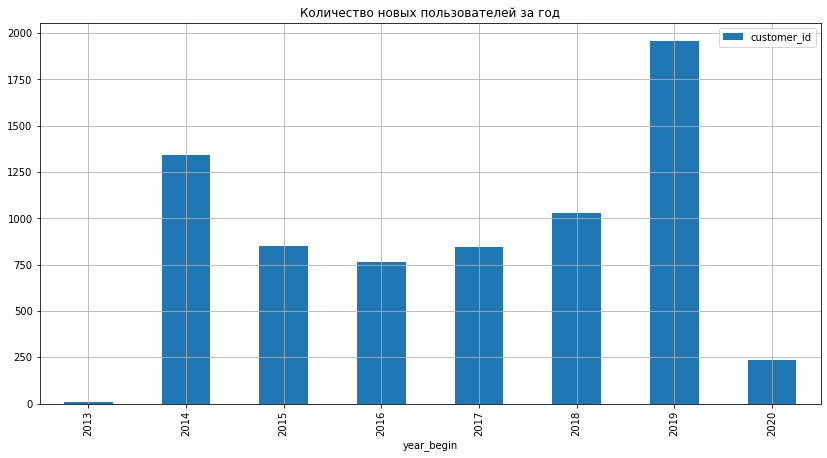

In [143]:
initial_data.pivot_table(index='year_begin', values='customer_id', aggfunc='count').plot.bar(
    figsize=(14, 7), title='Количество новых пользователей за год', grid=True)

Данные за 2013 и 2020 годы выглядят странно, проверим их.

In [144]:
initial_data.query('year_begin == 2013').month_begin.unique()

array([11, 10, 12])

In [145]:
initial_data.query('year_begin == 2020').month_begin.unique()

array([1])

Данные за эти два года неполные, поэтому их использование в дальнейшем лишь создаст ненужный шум. Удалим их из таблицы. 

Что касается остальных лет, то мы можем видеть,что после 2014 года количество новых клиентов компании сильно сократилось и достигло своего минимума (менее 800 новых пользователей) в 2016 году. Затем статистика медленно пошла вверх, пока не случился резкий всплеск в 2019 году (примерно 1950 новых пользователей). По имеющимся в нашем распоряжении данным сложно сделать вывод, с чем это связано. Возможно, компания освоила новый регион или провела успешную пиар-компанию. Также приток клиентов может быть связан с конкурентами заказчика (уход с рынка, ухудшение условий, повышение цен и тд.). 

Было бы интересно взглянуть на данные за 2020 год и посмотреть, как пандемия повлияла на динамику контрактов, но, к сожалению, за этот год, как уже было выяснено, мы имеем лишь неполные данные.

Теперь исследуем динамику притока клиентов по месяцам за период с 2017 по 2019 годы.

In [146]:
initial_data = initial_data.query('year_begin > 2013 and year_begin < 2020') #удаляем неполные данные

<AxesSubplot:title={'center':'Количество новых пользователей по месяцам в 2017 году'}, xlabel='month_begin'>

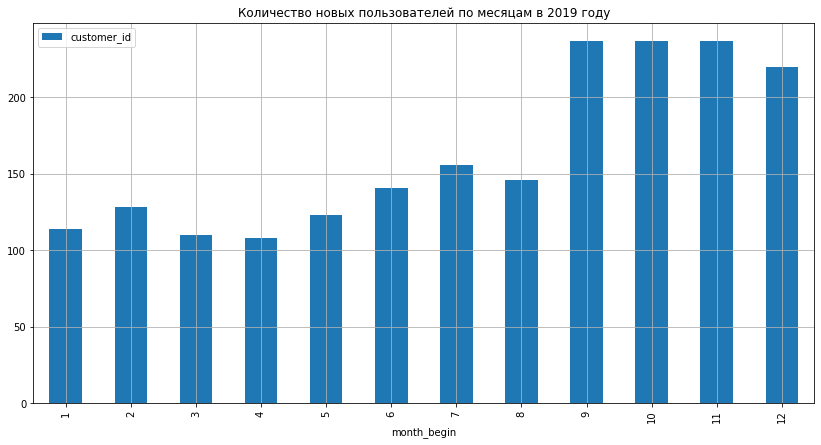

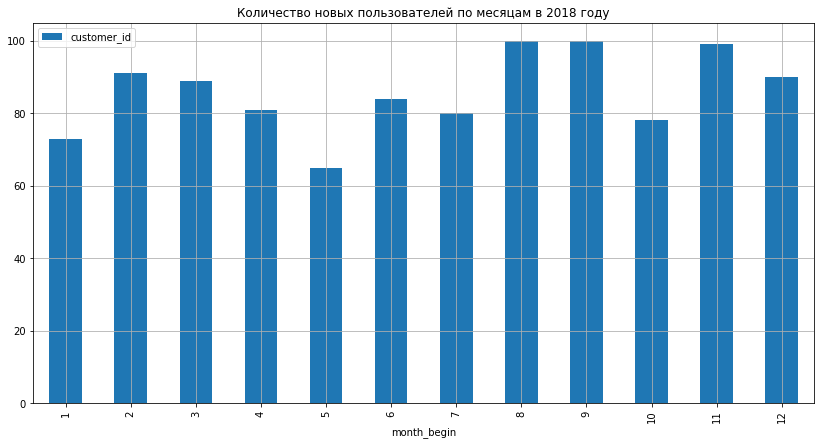

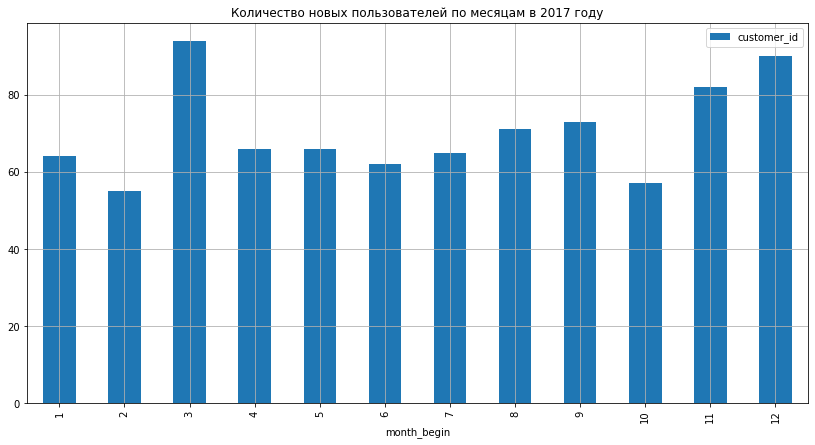

In [147]:
#строим графики по месяцам
initial_data.query('year_begin == 2019').pivot_table(index='month_begin', values='customer_id', aggfunc='count').plot.bar(
    figsize=(14, 7), title='Количество новых пользователей по месяцам в 2019 году', grid = True)
initial_data.query('year_begin == 2018').pivot_table(index='month_begin', values='customer_id', aggfunc='count').plot.bar(
    figsize=(14, 7), title='Количество новых пользователей по месяцам в 2018 году', grid = True)
initial_data.query('year_begin == 2017').pivot_table(index='month_begin', values='customer_id', aggfunc='count').plot.bar(
    figsize=(14, 7), title='Количество новых пользователей по месяцам в 2017 году', grid = True)

Изучив данные графики, можно отметить следующие моменты:
- самый равномерный год - 2019, в нем можно проследить тренд на постепенное увеличение заключаемых контрактов;
- в 2018 и 2019 годах самыми результативными месяцами стали сентябрь и ноябрь, а в декабре в оба года наблюдался спад;
- помимо выше названных, в 2019 году большой приток клиентов был отмечен в октябре (в предыдущие годы в этот месяц контракты наоборот "проседали", в 2018 - в августе, в 2017 - в марте (самый результативный месяц года по данному показателю).

Т. е. четкой закономерности, сохраняющейся из года в год, выявить не удалось.

Далее исследуем данные о клиентах, которые перестали сотрудничать с компанией-заказчиком.

<AxesSubplot:title={'center':'Количество ушедших пользователей в зависимости от типа контракта'}, xlabel='type_of_contract'>

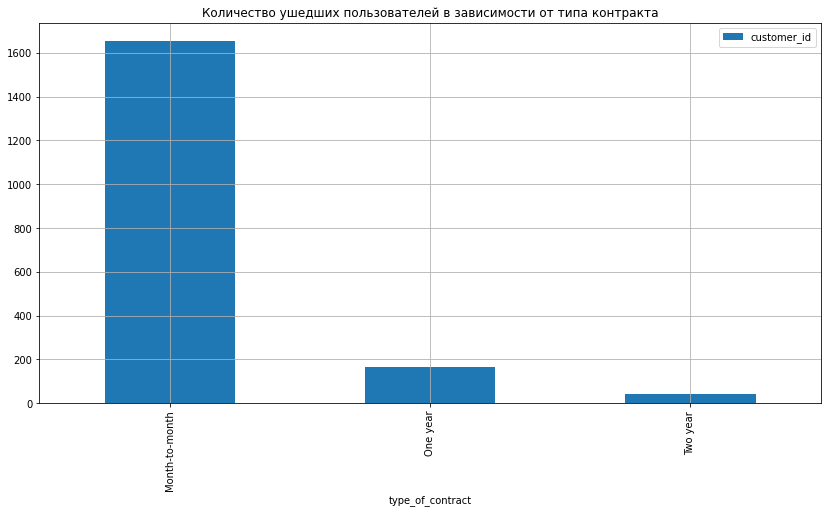

In [148]:
#вычленяем данные, относящиеся к ушедшим клиентам
gone = initial_data.query('left_or_stay == 1')
#строим график зависимости количества ушедших клиентов от типа заключенного контракта
gone.pivot_table(index='type_of_contract', values='customer_id', aggfunc='count').plot.bar(
    figsize=(14, 7), title='Количество ушедших пользователей в зависимости от типа контракта', grid = True)

График показал вполне ожидаемые и логичные результаты: большинство ушедших клиентов имели контракт с помесячной оплатой. Логично это по нескольким причинам. Во-первых, при помесячной оплате клиент имеет возможность протестировать качество предоставляемых услуг, соотнести его с их ценой и в любой момент сделать вывод, устраивает ли его подобное соотношение. Во-вторых, когда контракт заключен на целый год или два, люди менее охотно его разрывают, к тому же, с большой долей вероятности, контрактом предусмотрена определенная сумма неустойки при досрочном расторжении.

Теперь посмотрим, как количество ушедших клиентов зависит от длительности их отношений с компанией. Вполне возможно, что следующий график в определенной мере подтвердит предыдущие предположения.

<AxesSubplot:title={'center':'Количество ушедших пользователей в зависимости от длительности отношений с компанией'}, xlabel='count_months'>

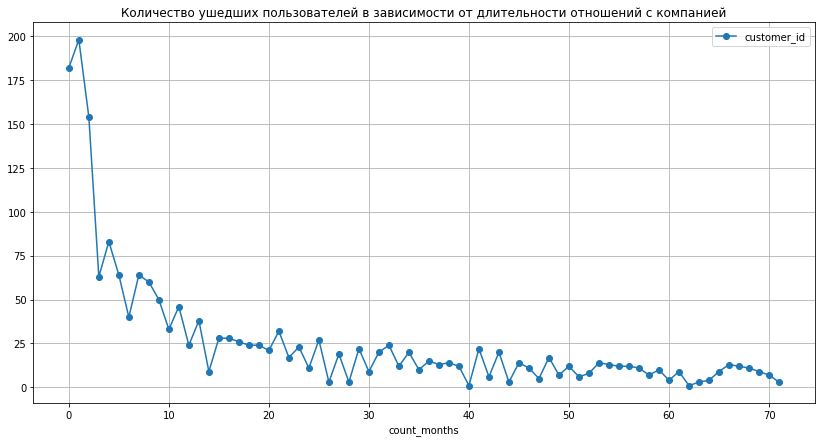

In [149]:
gone.pivot_table(index='count_months', values='customer_id', aggfunc='count').plot( style='o-', grid=True, 
                 figsize=(14, 7), title='Количество ушедших пользователей в зависимости от длительности отношений с компанией')

Действительно, мы можем видеть, что большинство клиентов уходит после первого месяца использования услуг. Скорее всего, это время как раз становится тестовым периодом. Также довольно большая доля клиентов разрывает контракт после двух месяцев, а затем, чем дольше клиент остается с компанией, тем реже он принимает решение о ее смене.

Далее изучим, как соотносятся траты ушедших и оставшихся клиентов.

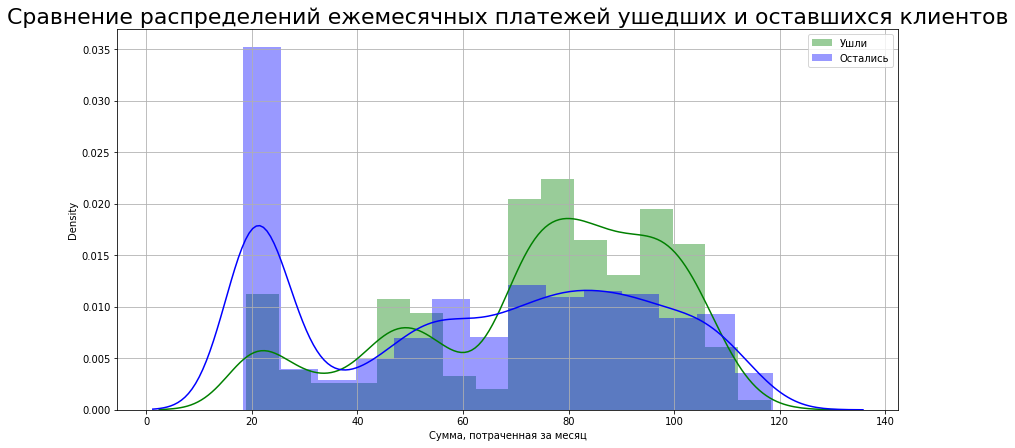

In [150]:
#вычленяем данные, относящиеся к оставшимся клиентам
stay = initial_data.query('left_or_stay == 0')

#строим график
plt.figure(figsize=(14,7))
sns.distplot(gone['monthly_charges'], color="g", label="Ушли")
sns.distplot(stay['monthly_charges'], color="b", label="Остались")
plt.title('Сравнение распределений ежемесячных платежей ушедших и оставшихся клиентов', fontsize=22)
plt.legend()
plt.xlabel('Сумма, потраченная за месяц')
plt.grid()
plt.show()

Как показывает график, ушедшие клиенты обычно тратят больше, чем те, кто по-прежнему остается с компанией.

На данном этапе мы получили все необходимое от данных с номером клиента, датой заключения и расторжения контрактов, поэтому можем удалить соответствующие столбцы. После этого необходимо исследовать целевой признак на предмет дисбаланска классов.

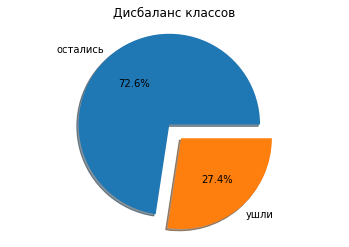

In [151]:
#избавляемся от избыточных данных
initial_data = initial_data.drop(['customer_id', 'date_begin', 'end_date', 'month_begin', 'year_begin'], axis = 1) 

#графически исследуем дисбаланс классов
fig, ax = plt.subplots()
ax.pie(initial_data['left_or_stay'].value_counts(), labels=['остались', 'ушли'], autopct='%.1f%%', shadow=True, explode=[0, 0.2])
ax.axis("equal")
plt.title('Дисбаланс классов')
plt.show()

Как мы видим, наблюдается сильный дисбаланс классов, который может оказать существенное влияние на работу моделей машинного обучения. Следовательно, на следующих этапах необходимо его устранить. 

Далее изучим взаимосвязи, существующие между признаками, и проверим данные на наличие мультиколлинеарности. 

<AxesSubplot:>

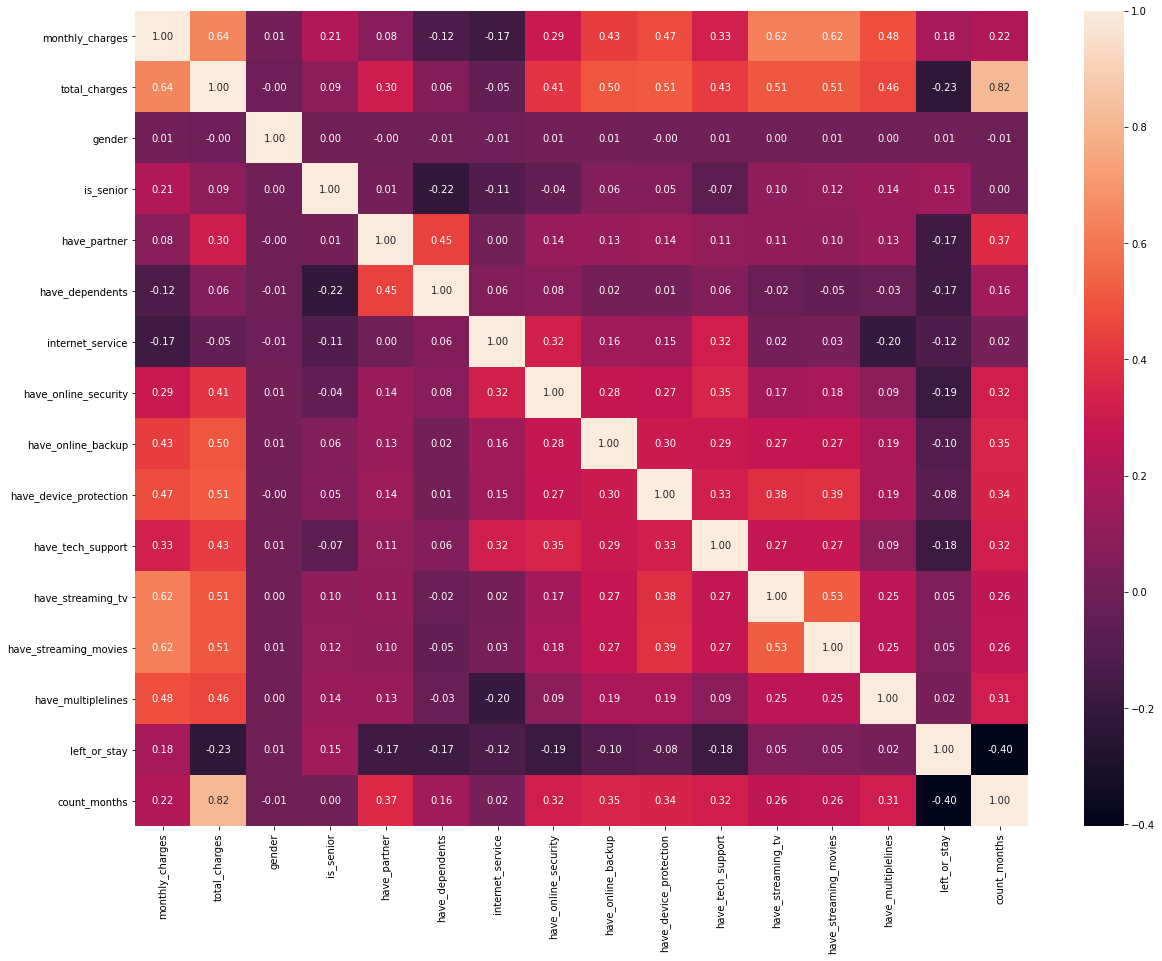

In [152]:
plt.figure(figsize=(20, 15))
sns.heatmap(initial_data.corr(), annot=True, color='#8a1c2e', fmt='.2f')

Построенный график позволил нам выявить наличие в данных мультиколлинеарности между столбцами count_months и total_charges (коэффициент корреляции равен 0,82). Оба играют важную роль, однако помимо них в данных есть столбцец с данными о ежемесячных тратах, поэтому, на мой взгляд, логичным решением будет удалить именно столбец total_charges.

In [153]:
initial_data = initial_data.drop(['total_charges'], axis = 1) 

На этом исследовательский анализ данных можно считать завершенным.

### Выводы:

После объединения таблиц были обработаны пропуски, переименованы столбцы, удалены избыточные данные, изменены форматы данных, устранена мультиколлинеарность. 

Исследовательский анализ показал следующее:
- значительное увеличение числа новых клиентов в 2019 году;
- чаще из компании уходят клиенты с помесячной оплатой;
- чем дольше клиент с компанией, тем меньше вероятность его ухода;
- большинство клиентов уходит после 1-2 месяцев;
- ушедшие клиенты, в основном, ежемесячно тратят больше тех, кто остается;
- выявлен сильный дисбаланс классов целевого признака;
- выявлена сильная взаимосвязь между данными столбцов total_charges и count_months.

## Подготовка данных к машинному обучению

Для начала преобразуем категориальные признаки в численные, используя технику прямого кодирования (OHE). Чтобы избежать дамми-ловушки, применим аргумент drop_first.

In [154]:
initial_data = pd.get_dummies(initial_data, drop_first=True) #преобразовываем категориальные признаки
initial_data.head() #проверяем результат

,monthly_charges,gender,is_senior,have_partner,have_dependents,internet_service,have_online_security,have_online_backup,have_device_protection,have_tech_support,have_streaming_tv,have_streaming_movies,have_multiplelines,left_or_stay,count_months,type_of_contract_One year,type_of_contract_Two year,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check
1,56.95,0,0,0,0,1,1,0,1,0,0,0,0,0,34,1,0,0,0,1
2,53.85,0,0,0,0,1,1,1,0,0,0,0,0,1,2,0,0,0,0,1
3,42.30,0,0,0,0,1,1,0,1,1,0,0,0,0,45,1,0,0,0,0
4,70.70,1,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,1,0
5,99.65,1,0,0,0,0,0,0,1,0,1,1,1,1,8,0,0,0,1,0


Далее разделим имеющиеся данные на обучающую, валидационную и тестовые выборки. Т.к. в дальнейшем мы будем производить балансировку данных, скопируем целевой и остальные признаки для сохранения их первоначального вида.

In [155]:
#выделяем признаки и целевой признак
features = initial_data.drop(['left_or_stay'], axis=1) 
target = initial_data['left_or_stay'] 

#создаем копии для дальнейшего преобразования
features_ml = features.copy()
target_ml = target.copy()

#отделяем от общего объема данных тестовую выборку
features_ml, features_test, target_ml, target_test = train_test_split(features_ml, target_ml, test_size=0.2, random_state=12345)
#делим оставшиеся данные на обучающую и валидационную выборки (в т.ч. для балансировки)
features_train_ml, features_valid_ml, target_train_ml, target_valid_ml = train_test_split(features_ml, target_ml, 
                                                                                          test_size=0.25, random_state=12345)
features_train, features_valid, target_train, target_valid = train_test_split(features_ml, target_ml, test_size=0.25, 
                                                                              random_state=12345)

#выводим на экран размеры получившихся выборок
print(features_train.shape, features_valid.shape, features_train_ml.shape, features_valid_ml.shape,features_test.shape)
print(target_train.shape, target_valid.shape, target_train_ml.shape, target_valid_ml.shape, target_test.shape)

(4074, 19) (1358, 19) (4074, 19) (1358, 19) (1359, 19)
(4074,) (1358,) (4074,) (1358,) (1359,)


По мнению некоторых экспертов, перебалансировка данных не оказывает никакого влияния на значение метрики AUC-ROC, с которой мы будем работать в дальнейшем. Другие считают, что данная метрика в принципе не подходит для оценки качества модели в задаче с несбалансированными классами. Однако мы все же произведем перебалансировку методом downsample и сравним результаты на валидационной выборке.

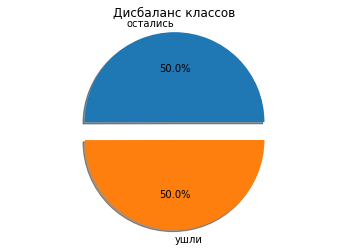

In [156]:
def downsample(features, target, fraction): #создаем функцию
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)
    return features_downsampled, target_downsampled

#применяем ее к обучающей выборке
features_downsampled, target_downsampled = downsample(features_train_ml, target_train_ml, 0.377)

#проверяем сбалансированность классов
fig, ax = plt.subplots()
ax.pie(target_downsampled.value_counts(), labels=['остались', 'ушли'], autopct='%.1f%%', shadow=True, 
       explode=[0, 0.2])
ax.axis("equal")
plt.title('Дисбаланс классов')
plt.show()

С помощью уменьшения выборки было достигнуто равенство классов. 

На этом подготовку данных можно считать оконченной, далее перейдем к обучению моделей.

### Выводы:

В ходе подготовки данных к машинному обучению были произведены:
- преобразование категориальных признаков в численные;
- выделение целевого признака;
- разделение данных на три выборки;
- перебалансировка классов целевого признака.

## Обучение моделей

Перейдем к обучению моделей. В ходе данного проекта обучим модели случайного леса и LGBM. Также на этом этапе сравним метрики моделей, обученных на сбалансированных и исходных данных, полученные на валидационных выборках. 

Помимо ключевой метрики AUC-ROC для сравнения моделей и выбора искомого прототипа мы также подсчитаем accuracy и - т.к. она не подходит для несбалансированных данных - F1-меру. 

Начнем с модели случайного леса:

In [157]:
#обучаем случайный лес на сбалансированных данных
best_forest_model_balanced = None
best_forest_f1 = 0
best_forest_estimators = 0
best_forest_depth = 0
best_auc_roc_forest = 0
best_accuracy_forest = 0

for est in range(100, 250, 25):
    for depth in range(1,21):
            model_forest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
            model_forest.fit(features_downsampled, target_downsampled)
            predictions_valid = model_forest.predict(features_valid_ml)
            f1_forest = f1_score(target_valid_ml, predictions_valid)
            probabilities_valid = model_forest.predict_proba(features_valid_ml)
            probabilities_one_valid = probabilities_valid[:, 1]
            auc_roc_forest = roc_auc_score(target_valid_ml, probabilities_one_valid)
            accuracy_forest = accuracy_score(target_valid_ml, predictions_valid)
            if f1_forest > best_forest_f1:
                best_forest_model_balanced = model_forest
                best_forest_f1 = f1_forest
                best_forest_estimators = est
                best_forest_depth = depth
                best_auc_roc_forest = auc_roc_forest
                best_accuracy_forest = accuracy_forest
                
print('Лучшее количество деревьев:', best_forest_estimators)
print('Лучшая глубина модели:', best_forest_depth)
print('Метрики случайного леса для сбалансированных данных: F1-мера', best_forest_f1.round(2), ', AUC-ROC', best_auc_roc_forest.round(2), 
     ', Accuracy', best_accuracy_forest.round(2))

Лучшее количество деревьев: 125
Лучшая глубина модели: 8
Метрики случайного леса для сбалансированных данных: F1-мера 0.68 , AUC-ROC 0.86 , Accuracy 0.77


In [158]:
#обучаем случайный лес на несбалансированных данных
best_forest_model = None
best_forest_f1 = 0
best_forest_estimators = 0
best_forest_depth = 0
best_auc_roc_forest = 0

for est in range(100, 250, 25):
    for depth in range(1,21):
            model_forest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
            model_forest.fit(features_train, target_train)
            predictions_valid = model_forest.predict(features_valid)
            f1_forest = f1_score(target_valid, predictions_valid)
            probabilities_valid = model_forest.predict_proba(features_valid)
            probabilities_one_valid = probabilities_valid[:, 1]
            auc_roc_forest = roc_auc_score(target_valid, probabilities_one_valid)
            accuracy_forest = accuracy_score(target_valid, predictions_valid)
            if f1_forest > best_forest_f1:
                best_forest_model = model_forest
                best_forest_f1 = f1_forest
                best_forest_estimators = est
                best_forest_depth = depth
                best_auc_roc_forest = auc_roc_forest
                
print('Лучшее количество деревьев:', best_forest_estimators)
print('Лучшая глубина модели:', best_forest_depth)
print('Метрики случайного леса: F1-мера', best_forest_f1.round(2), ', AUC-ROC', best_auc_roc_forest.round(2))

Лучшее количество деревьев: 125
Лучшая глубина модели: 9
Метрики случайного леса: F1-мера 0.64 , AUC-ROC 0.86


Значение метрики F1-меры в случае со случайным лесом оказалось выше у модели, обученной на сбалансированных данных. При этом метрика AUC-ROC показала одинаковые значения у обеих моделей. 

Посмотрим, что покажет LGB-модель:

In [159]:
#обучаем LGB на сбалансированных данных
lgb_model_balanced = lgb.LGBMClassifier (objective = 'binary', num_boost_round = 50).fit(features_downsampled, 
                                         target_downsampled, eval_set = [(features_valid_ml, target_valid_ml)])
probabilities_valid_lgb = lgb_model_balanced.predict_proba(features_valid_ml)
probabilities_one_valid_lgb = probabilities_valid_lgb[:, 1]
lgb_predictions = lgb_model_balanced.predict(features_valid_ml)
f1_lgb = f1_score(target_valid_ml, lgb_predictions)
auc_roc_lgb = roc_auc_score(target_valid_ml, probabilities_one_valid_lgb)
accuracy_lgb = accuracy_score(target_valid_ml, lgb_predictions)

[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[1]	valid_0's binary_logloss: 0.654368
[2]	valid_0's binary_logloss: 0.624056
[3]	valid_0's binary_logloss: 0.600664
[4]	valid_0's binary_logloss: 0.579248
[5]	valid_0's binary_logloss: 0.562092
[6]	valid_0's binary_logloss: 0.547159
[7]	valid_0's binary_logloss: 0.533862
[8]	valid_0's binary_logloss: 0.521976
[9]	valid_0's binary_logloss: 0.51265
[10]	valid_0's binary_logloss: 0.504482
[11]	valid_0's binary_logloss: 0.497298
[12]	valid_0's binary_logloss: 0.491183
[13]	valid_0's binary_logloss: 0.486315
[14]	valid_0's binary_logloss: 0.482679
[15]	valid_0's binary_logloss: 0.479189
[16]	valid_0's binary_logloss: 0.477124
[17]	valid_0's binary_logloss: 0.474022
[18]	valid_0's binary_logloss: 0.471908
[19]	valid_0's binary_logloss: 0.469436
[20]	valid_0's binary_logloss: 0.467673
[21]	valid_0's binary_logloss: 0.466403
[22]	valid_0's binary_logloss: 0.465311
[23]	valid_0's

In [160]:
print('Метрики LGB для сбалансированных данных: F1-мера', f1_lgb.round(2), ', AUC-ROC', auc_roc_lgb.round(2), ', Accuracy', 
      accuracy_lgb.round(2))

Метрики LGB для сбалансированных данных: F1-мера 0.66 , AUC-ROC 0.86 , Accuracy 0.76


In [161]:
#обучаем LGB на несбалансированных данных
lgb_model = lgb.LGBMClassifier (objective = 'binary', num_boost_round = 50).fit(features_train, 
                                         target_train, eval_set = [(features_valid, target_valid)])
probabilities_valid_lgb = lgb_model.predict_proba(features_valid)
probabilities_one_valid_lgb = probabilities_valid_lgb[:, 1]
lgb_predictions = lgb_model.predict(features_valid)
f1_lgb = f1_score(target_valid, lgb_predictions)
auc_roc_lgb = roc_auc_score(target_valid, probabilities_one_valid_lgb)

[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[1]	valid_0's binary_logloss: 0.56699
[2]	valid_0's binary_logloss: 0.539522
[3]	valid_0's binary_logloss: 0.518065
[4]	valid_0's binary_logloss: 0.500039
[5]	valid_0's binary_logloss: 0.484708
[6]	valid_0's binary_logloss: 0.472451
[7]	valid_0's binary_logloss: 0.461747
[8]	valid_0's binary_logloss: 0.453384
[9]	valid_0's binary_logloss: 0.445601
[10]	valid_0's binary_logloss: 0.439429
[11]	valid_0's binary_logloss: 0.433117
[12]	valid_0's binary_logloss: 0.428767
[13]	valid_0's binary_logloss: 0.42523
[14]	valid_0's binary_logloss: 0.421947
[15]	valid_0's binary_logloss: 0.419308
[16]	valid_0's binary_logloss: 0.417002
[17]	valid_0's binary_logloss: 0.414809
[18]	valid_0's binary_logloss: 0.412711
[19]	valid_0's binary_logloss: 0.411188
[20]	valid_0's binary_logloss: 0.41042
[21]	valid_0's binary_logloss: 0.409518
[22]	valid_0's binary_logloss: 0.407945
[23]	valid_0's b

In [162]:
print('Метрики LGB для несбалансированных данных: F1-мера', f1_lgb.round(2), ', AUC-ROC', auc_roc_lgb.round(2))

Метрики LGB для несбалансированных данных: F1-мера 0.63 , AUC-ROC 0.86


Модель LGB, обученная на сбалансированных данных, также показала лучший результат F1-меры и то же значение метрики AUC-ROC. При этом в целом у данной модели метрики чуть ниже, чем у случайного леса (в т.ч. и точность сбалансированной модели случайного леса выше точности сбалансированнной модели LGB).

### Выводы:

На данном этапе мы обсучили модели случайного леса и LGB на сбалансированных и несбалансированных данных и сравнили их метрики, полученные на валидационной выборке. 

Более высокие результаты показали сбалансированные модели, поэтому в дальнейшем тестировать мы будем именно их. Лидером стала модель случайного леса. 

На следующем этапе протестируем обе модели на тестовой выборке.

## Тестирование моделей

Протестируем получившиеся и сохраненные лучшие модели на тестовой выборке. Проверять будем в том же порядке, в каком модели обучались. 

In [163]:
#тестируем случайный лес
predictions_test = best_forest_model_balanced.predict(features_test)
f1_forest_test = f1_score(target_test, predictions_test)
predict_proba_test = best_forest_model_balanced.predict_proba(features_test)
probabilities_one_test = predict_proba_test[:, 1]
auc_roc_forest = roc_auc_score(target_test, probabilities_one_test)
accuracy_forest = accuracy_score(target_test, predictions_test)

#тестируем LGB
predict_proba_test_lgb = lgb_model_balanced.predict_proba(features_test)
probabilities_one_valid_lgb_test = predict_proba_test_lgb[:, 1]
lgb_predictions_test = lgb_model_balanced.predict(features_test)
f1_lgb_test = f1_score(target_test, lgb_predictions_test)
auc_roc_lgb_test = roc_auc_score(target_test, probabilities_one_valid_lgb_test)
accuracy_lgb_test = accuracy_score(target_test, lgb_predictions_test)

#выводим результаты на экран для сравнения
print('Метрики случайного леса для тестовых данных: F1-мера', f1_forest_test.round(2), ', AUC-ROC', auc_roc_forest.round(2),
      ', Accuracy', accuracy_forest.round(2))
print('Метрики LGB для тестовых данных: F1-мера', f1_lgb_test.round(2), ', AUC-ROC', auc_roc_lgb_test.round(2), 
      ', Accuracy', accuracy_lgb_test.round(2))

Метрики случайного леса для тестовых данных: F1-мера 0.65 , AUC-ROC 0.87 , Accuracy 0.77
Метрики LGB для тестовых данных: F1-мера 0.63 , AUC-ROC 0.87 , Accuracy 0.77


При тестировании модели показали максимально близкие результаты, различия есть лишь в значениях F1-меры, однако и они крайне малы. Но, т.к. нам все же необходимо выбрать одну модель, которая будет предложена заказчику в качестве прототипа, то эти различия сыграют ключевую роль.

F1-мера выше у модели случайного леса, следовательно, именно она станет искомой моделью.

Напоследок изучим, какие признаки играли определяющую роли и оказывали наибольшее влияние на целевой признак. Анализ проведем на основе выбранной модели.

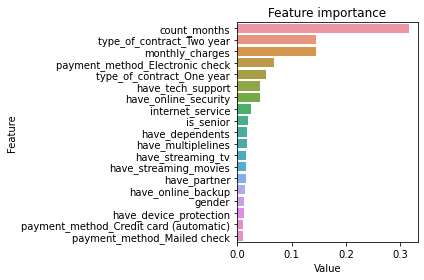

In [164]:
feature_importance = best_forest_model_balanced.feature_importances_
feature_imp = pd.DataFrame(sorted(zip(feature_importance, features.columns)), columns=['Value','Feature'])
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Feature importance')
plt.tight_layout()
plt.show();

На графике четко выделены три признака, оказывающих наибольшее влияние на целевой признак: длительность отношений с клиентом в месяцах, двухгодичный тип контракта и ежемесячные траты клиента. При этом влияние первого из указанных признаков почти в два раза превышает влияние второго и третьего, которые, в свою очередь, показали одинаковый результат. 

Остальные исследованные признаки влияют на целевой признак гораздо слабее.

### Выводы:

На тестовой выборке модели показали практически идентичные результаты, однако значение F1-меры оказалось выше у модели случайного леса. Кроме того удалось достичь достаточно высокого значения метрики AUC-ROC: 0.87. 

На этом исследование можно считать завершенным, переходим к итоговым выводам.

## Итоговые выводы

В ходе данного проекта были исследованы две модели машинного обучения: случайный лес и LGB. Необходимо было построить  прототип модели машинного обучения для предсказывания ухода клиентов компании с предельно высоким значением метрики AUC-ROC. Результаты исследования позволили прийти к следующим выводам:
- искомой моделью стала модель случайного леса, обученная на сбалансированных данных, с количеством деревьев - 125 и глубиной модели равной 8. Значение AUC-ROC на валидационной выборке составило 0.86, на тестовой - 0.87;
- на работу обеих моделей баланс классов целевого признака, полученный путем уменьшения выборки обучающих данных, оказал слабое отрицательное влияние;
- наибольшее влияние на целевой признак в выбранной модели оказал признак длительности отношений компании с клиентом, выраженный в месяцах;
- чаще из компании уходят клиенты с помесячной оплатой;
- большинство клиентов уходит после 1-2 месяцев, и чем более длительные отношения с клиентом, тем ниже вероятность его ухода из компании;
- ушедшие клиенты, в основном, ежемесячно тратят больше тех, кто остается.